In [1]:
from diffusers import StableDiffusionPipeline

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Settings for stable diffusion

In [2]:
# Some settings
prompt = ["Acrylic palette knife painting of a flower"]  # What we want to generate
height = 512
# default height of Stable Diffusion
width = 512
num_inference_steps = 30  # default width of Stable Diffusion
# Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
seed = 42

#### Tokenize the input and pass it through the encoder, also do the tokenization for the unconditional input, then concatenate both

In [3]:
# Tokenize the input
text_input = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True,
                            return_tensors="pt")

# Feed through the text encoder
with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

# Do the same for the unconditional input (a blank string)
uncond_input = pipe.tokenizer("", padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

# Concatenate the two sets of text  embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

##### Prepare the scheduler

In [5]:
# Prepare the Scheduler
pipe.scheduler.set_timesteps(num_inference_steps)

# Prepare the random starting latents
latents = torch.randn(
    (1, pipe.unet.config.in_channels, height // 8, width // 8),  # Shape of the latent representation
    generator=torch.manual_seed(32),  # Seed the random number generator
).to(device).half()
latents = latents * pipe.scheduler.init_noise_sigma

##### Sampling

In [6]:
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"

# Sampling loop
for i, t in enumerate(pipe.scheduler.timesteps):
    # Create two copies of the latents to match the two text embeddings (unconditional and conditional)
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual for both sets of inputs
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Split the prediction into unconditional and conditional versions:
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    # perform classifier-free guidance
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:264.)
  hidden_states = F.scaled_dot_product_attention(
/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1279: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:320.)
  hidden_states = F.scaled_dot_product_attention(


##### Generate image using VAE

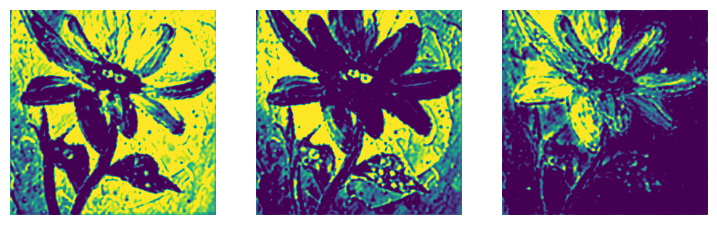

In [8]:
from utils import show_images
from diffusers import AutoencoderKL

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to(
    "cuda")

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)

# Display
my_image = show_images(image[0].float())
my_image